In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [5]:
# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [6]:
!ls data/MNIST/raw

t10k-images-idx3-ubyte     train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte     train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [7]:
# Split train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

Displaying random images from the training set:


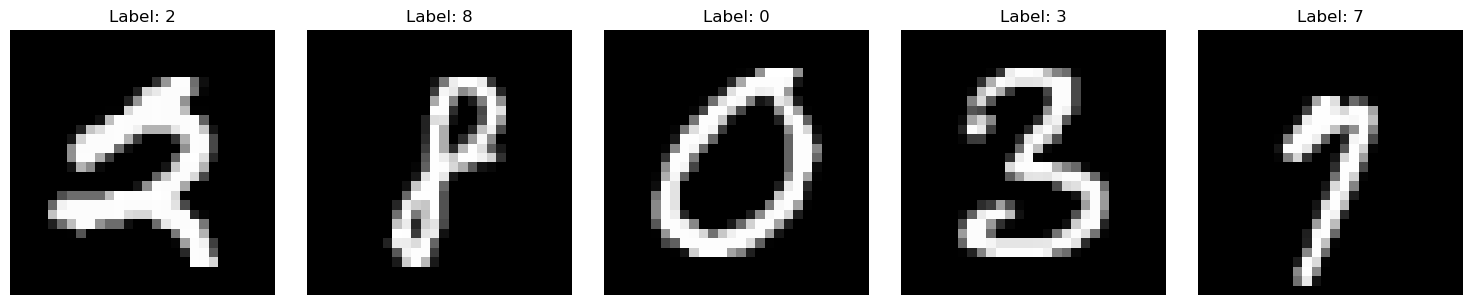

In [15]:
# Function to display random images from the dataset
def display_random_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[idx]
        img = img.squeeze().numpy()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Display random images from the training set
print("Displaying random images from the training set:")
display_random_images(train_dataset)

In [8]:
# Create a full-batch loader for simple gradient descent
full_batch_loader = DataLoader(train_dataset, batch_size=train_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [9]:
# Define the logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(28 * 28, 10)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.linear(x)

In [10]:
# Initialize the model, loss function, and optimizer
model = LogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [12]:
# Validation function
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

`model.train()` is called at the beginning of each training epoch. This ensures that:

- If the model has dropout layers, they will be active during training.
- If the model has batch normalization layers, they will update their running statistics.

`optimizer.zero_grad()` is called at the beginning of each batch. This ensures that:

- The gradients from the previous batch don't interfere with the current batch.
- Each batch starts with a clean slate for gradient computation.


`model.eval()` is called before the evaluation phase. This ensures that:

- Dropout layers (if any) don't drop any neurons during evaluation.
- Batch normalization layers (if any) use their stored statistics instead of computing batch statistics.


`torch.no_grad()` is used during evaluation to disable gradient computation, which:

- Saves memory
- Speeds up computation
- Is appropriate since we're not updating the model during evaluation

In [13]:
# Simple Gradient Descent loop
model_gd = LogisticRegression()
optimizer_gd = optim.SGD(model_gd.parameters(), lr=0.01)

num_epochs_gd = 50
train_losses_gd, train_accuracies_gd = [], []
val_losses_gd, val_accuracies_gd = [], []

for epoch in range(num_epochs_gd):
    model.train()
    for images, labels in full_batch_loader:
        optimizer_gd.zero_grad()
        outputs = model_gd(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_gd.step()
    
    train_loss, train_acc = validate(model_gd, full_batch_loader, criterion)
    val_loss, val_acc = validate(model_gd, val_loader, criterion)
    
    train_losses_gd.append(train_loss)
    train_accuracies_gd.append(train_acc)
    val_losses_gd.append(val_loss)
    val_accuracies_gd.append(val_acc)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs_gd}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print()

Epoch 10/50:
Train Loss: 1.6096, Train Acc: 59.07%
Val Loss: 1.6109, Val Acc: 59.00%

Epoch 20/50:
Train Loss: 1.2130, Train Acc: 72.27%
Val Loss: 1.2175, Val Acc: 71.44%

Epoch 30/50:
Train Loss: 1.0051, Train Acc: 77.64%
Val Loss: 1.0118, Val Acc: 77.21%

Epoch 40/50:
Train Loss: 0.8793, Train Acc: 80.40%
Val Loss: 0.8875, Val Acc: 79.93%

Epoch 50/50:
Train Loss: 0.7952, Train Acc: 82.14%
Val Loss: 0.8044, Val Acc: 81.65%



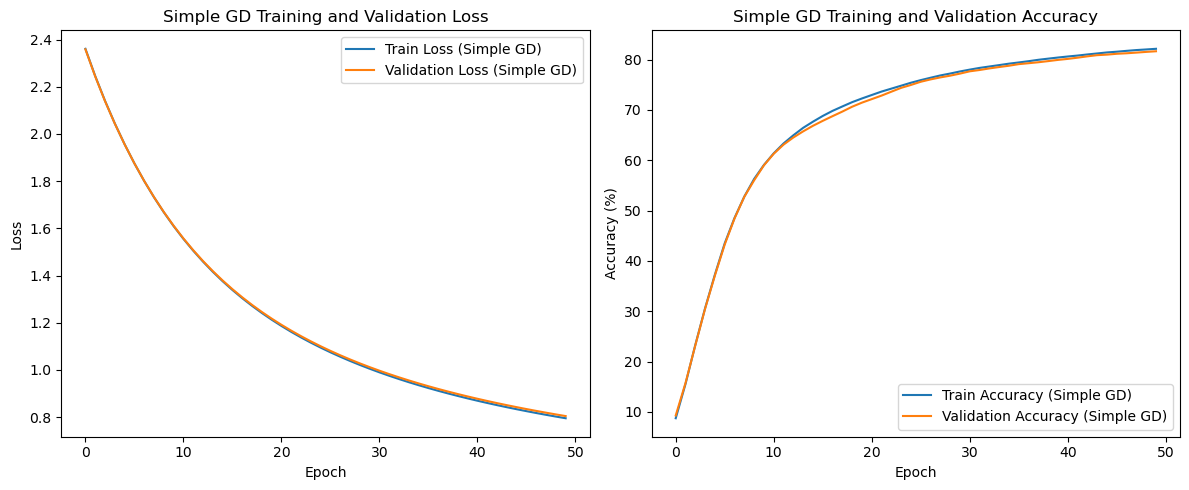

Simple GD Test Loss: 0.7737, Simple GD Test Acc: 82.93%


In [14]:
# Plot Simple GD training and validation losses and accuracies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_gd, label='Train Loss (Simple GD)')
plt.plot(val_losses_gd, label='Validation Loss (Simple GD)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Simple GD Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_gd, label='Train Accuracy (Simple GD)')
plt.plot(val_accuracies_gd, label='Validation Accuracy (Simple GD)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Simple GD Training and Validation Accuracy')
plt.tight_layout()
plt.show()

# Evaluate the Simple GD model on the test set
test_loss_gd, test_acc_gd = validate(model_gd, test_loader, criterion)
print(f"Simple GD Test Loss: {test_loss_gd:.4f}, Simple GD Test Acc: {test_acc_gd:.2f}%")

In [16]:
# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Epoch 1/5:
Train Loss: 0.3580, Train Acc: 90.03%
Val Loss: 0.3765, Val Acc: 89.30%

Epoch 2/5:
Train Loss: 0.3219, Train Acc: 90.81%
Val Loss: 0.3463, Val Acc: 90.20%

Epoch 3/5:
Train Loss: 0.3040, Train Acc: 91.42%
Val Loss: 0.3306, Val Acc: 90.83%

Epoch 4/5:
Train Loss: 0.2948, Train Acc: 91.72%
Val Loss: 0.3235, Val Acc: 90.87%

Epoch 5/5:
Train Loss: 0.2870, Train Acc: 91.96%
Val Loss: 0.3182, Val Acc: 90.95%



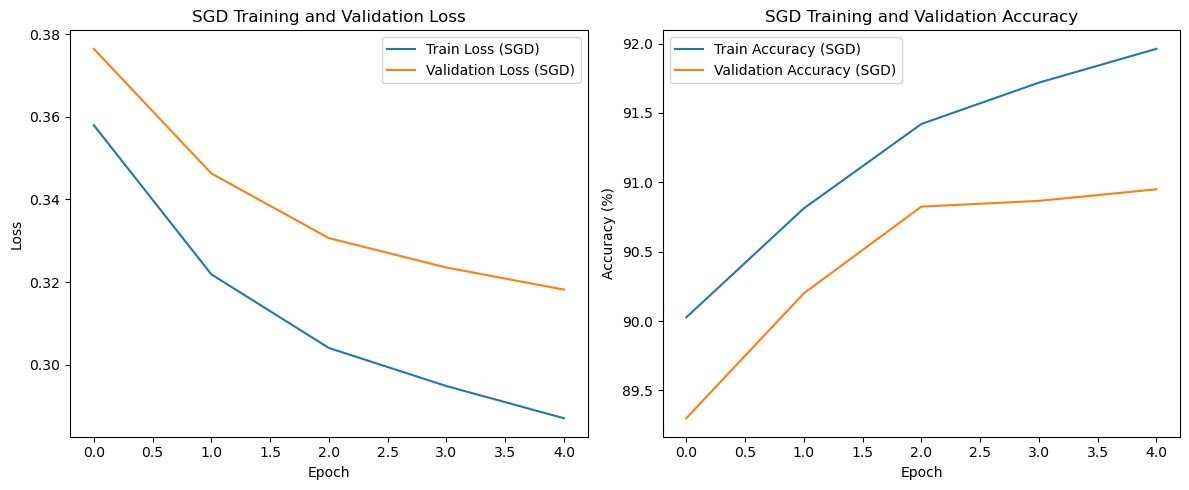

Test Loss: 2.5177, Test Acc: 9.17%
SGD Test Loss: 0.2884, SGD Test Acc: 91.92%


In [17]:
model_sgd = LogisticRegression()
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)

num_epochs_sgd = 5
train_losses_sgd, train_accuracies_sgd = [], []
val_losses_sgd, val_accuracies_sgd = [], []

for epoch in range(num_epochs_sgd):
    model.train()
    for images, labels in train_loader:
        optimizer_sgd.zero_grad()
        outputs = model_sgd(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_sgd.step()
    
    train_loss, train_acc = validate(model_sgd, train_loader, criterion)
    val_loss, val_acc = validate(model_sgd, val_loader, criterion)
    
    train_losses_sgd.append(train_loss)
    train_accuracies_sgd.append(train_acc)
    val_losses_sgd.append(val_loss)
    val_accuracies_sgd.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs_sgd}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print()

# Plot SGD training and validation losses and accuracies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_sgd, label='Train Loss (SGD)')
plt.plot(val_losses_sgd, label='Validation Loss (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('SGD Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_sgd, label='Train Accuracy (SGD)')
plt.plot(val_accuracies_sgd, label='Validation Accuracy (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('SGD Training and Validation Accuracy')
plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

# Evaluate the SGD model on the test set
test_loss_sgd, test_acc_sgd = validate(model_sgd, test_loader, criterion)
print(f"SGD Test Loss: {test_loss_sgd:.4f}, SGD Test Acc: {test_acc_sgd:.2f}%")